# ECON 323 Final Project
## Using Machine Learning to predict Market Falls with newspaper articles 

By: Juan Manuel Ochoa Graciano






## Introduction 
The aim of this project is to use newspaper articles to predict market movements based on a sentiment score. This tool could be potentially used as an alarm prior to a market crash, as well as, having an additional tool to understand market dynamics and how media can show patters related to finance activities.  

The news will be Scrapped from Reuters alongside an already existing database of articles available at https://www.kaggle.com/datasets/gennadiyr/us-equities-news-data 

This project will be divided into three main steps: 
1. Web scraping to recover articles
2. Data Base creation with: Sentiment, market movement per day, and other relevant 
variables 
3. Machine Learning predictions 


### Libraries

This section import all the libraries that will be used in the project 

In [1]:
import pandas as pd 
from pandas import concat
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, tree, metrics, neural_network, pipeline, preprocessing, model_selection, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix,accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

!pip install textblob
from textblob import TextBlob

%matplotlib inline

import scipy.stats as st

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)


### Web Scraping
This section downloads news from reuters using webscraping. We only download the title to further analysis in the program. In total we use 264,606 news from Reuters and Kaggle DataBase dating from 2008 until Nov 2022. 


In [4]:
#Download news from Reuters

url_list = ["https://www.reuters.com/news/archive?view=page&page=9"]
url = "https://www.reuters.com/news/archive?view=page&page="
title = []
date =[]
summ = []
dicc = pd.DataFrame(columns = ["title","date"])
final_dicc = pd.DataFrame()
remove = '</h3>, <h3 class="story-title">'
i=0


#Code for data download using beautiful soup to find the title, summary and date
page = range(330,1280)
for num in page:
  url_2 = url+str(num)+"&pageSize=10"
  url_list.append(url_2)
  #print(url_list)
  
for link in url_list:
  i+=1
  page = requests.get(link)
  soup = BeautifulSoup(page.text,'html.parser')
  results = soup.find_all("h3", class_="story-title")
  results.pop(-1)
  results.pop(-1)
  results.pop(-1)
  for result in results:
    title.append(result.string)
  
  date_art = soup.find_all("span", class_="timestamp")
  for dates in date_art:
    date.append(dates.string)
  

dicc["title"]= title
dicc["date"]= date
print(dicc)  

dicc.to_csv('news_reuters.csv')



                                                  title         date
0     \n\t\t\t\t\t\t\t\tIn Washington, Macron to see...  Nov 27 2022
1     \n\t\t\t\t\t\t\t\tAttention turns to president...  Nov 26 2022
2     \n\t\t\t\t\t\t\t\tProgressives returned for th...  Nov 26 2022
3     \n\t\t\t\t\t\t\t\tChevron can resume key role ...  Nov 26 2022
4     \n\t\t\t\t\t\t\t\tIrene Cara, star of 1980s cl...  Nov 26 2022
...                                                 ...          ...
9505  \n\t\t\t\t\t\t\t\tChina announces South China ...  Mar 05 2022
9506  \n\t\t\t\t\t\t\t\tAt least 58 killed in suicid...  Mar 05 2022
9507  \n\t\t\t\t\t\t\t\tRussian law on 'fake news' p...  Mar 05 2022
9508  \n\t\t\t\t\t\t\t\tU.S. Embassy in Ukraine call...  Mar 04 2022
9509  \n\t\t\t\t\t\t\t\tU.S. court allows Biden's Me...  Mar 04 2022

[9510 rows x 2 columns]


## Merge newspaper articles

Here we merge the data obtained from Reuters with another DataBase from Kaggle with data from 2008. To obtain a wider range of news due to the limit ammount of news available in Reuters. 

In [4]:
#Merge both databases titles 

reuters_title = pd.DataFrame()
reuters = pd.read_csv('news_reuters.csv', header=0).reset_index()
reuters_title["Date"] = pd.to_datetime(reuters["date"])
reuters_title["title"] = (reuters["title"])

historic_title = pd.DataFrame()
historic = pd.read_csv('news_database_20082022.csv', header=0).reset_index() #Historic
historic_title["Date"] = pd.to_datetime(historic["date"],dayfirst=True)
historic_title["title"] = (historic["title"])


#Create merged database 
merge=pd.concat([historic_title, reuters_title ], ignore_index=True).reset_index(drop=True)
merge.to_csv('MergeDataBase.csv')

df = (
    merge
    .reset_index()
    .pivot_table(index="Date")
)

merge.head()

,Date,title
0,2022-04-04,Georgian Foreign Minister David Zalkaliani...
1,2022-04-04,DUBAI (Reuters) -The United States is responsi...
2,2022-04-04,Military conscripts in the Russian-backed ...
3,2022-04-04,ISLAMABAD (Reuters) -Pakistan's political turm...
4,2022-04-04,Ukrainian President Volodymyr Zelenskiy on...


# Sentiment Analysis

Here we use the Vader program to create a "Positive or Negative" sentiment of the title we downloaded

In [4]:
#Create score sentiment  

vader_dict={}
sia = SentimentIntensityAnalyzer()
sentiment_dicc={}
datel=[]
positivel=[]
negativel=[]
neutrall=[]
compoundl=[]
sentiment_dicc={"Date":[], "Positive":[], "Negative":[], "Neutral":[], "Compound":[]}
finalsdf=pd.DataFrame()

titles_negative_score=0
titles_positive_score_=0
titles_neutral_score=0
titles_compound_score=0

data=pd.read_csv('MergeDataBase.csv', header=0)

for i in range(1, data.shape[0]):        
    title_score=sia.polarity_scores(str(data["title"][i]))
    datel.append(data["Date"][i])
    positivel.append(title_score["pos"])
    negativel.append(title_score["neg"])
    neutrall.append(title_score["neu"])
    compoundl.append(title_score["compound"])
   

sentiment_dicc["Date"]=datel 
sentiment_dicc["Positive"]=positivel
sentiment_dicc["Negative"]=negativel
sentiment_dicc["Neutral"]=neutrall
sentiment_dicc["Compound"]=compoundl
    

sdf = pd.DataFrame(sentiment_dicc, columns=['Date', 'Positive', 'Negative', 'Neutral', 'Compound' ],) 
finalsdf = finalsdf.append(sdf, ignore_index = True)

finalsdf.tail()

# Group by day each news 

df_scoreday_r = finalsdf.groupby(['Date']).sum()
df_scoreday_r.head()

/tmp/ipykernel_2621/3803358219.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalsdf = finalsdf.append(sdf, ignore_index = True)


,Positive,Negative,Neutral,Compound
Date,,,,
2008-10-02,0.000,0.450,0.550,-0.5994
2008-10-03,1.240,0.136,2.625,1.7976
2008-10-06,0.274,0.884,0.842,-1.3112
2008-10-07,0.000,0.555,1.445,-0.9209
2008-10-08,0.173,0.000,0.827,0.2235


## Create a DataBase 

We add different data to our Dataset for further analysis such as an Standard Deviation of the sentiment.

In [5]:
#CALCULATE STANDARD DEVS

df = finalsdf.sort_values(by = ['Date']) 

positive_day_dev = {}
neutral_day_dev = {}
negative_day_dev = {}
compound_day_dev = {}

dataframe_standard_dev = {"Date":[],
                          "Positive_day_st_dev":[],
                          "Neutral_day_st_dev":[],
                          "Negative_day_st_dev":[],
                          "Compound_day_st_dev":[]
                          }

#FOR POSITIVE
for i in range(df.shape[0]):
    if df["Date"][i] in positive_day_dev:
        positive_day_dev[df["Date"][i]].append(df["Positive"][i])
    else:
        positive_day_dev[df["Date"][i]] = []
        positive_day_dev[df["Date"][i]].append(df["Positive"][i])
for key in positive_day_dev:
    data = pd.Series(positive_day_dev[key])
    standard_dev = round(data.std(ddof=0),4)
    dataframe_standard_dev["Date"].append(key)
    dataframe_standard_dev["Positive_day_st_dev"].append(standard_dev)

#FOR NEUTRAL
for i in range(df.shape[0]):
    if df["Date"][i] in neutral_day_dev:
        neutral_day_dev[df["Date"][i]].append(df["Neutral"][i])
    else:
        neutral_day_dev[df["Date"][i]] = []
        neutral_day_dev[df["Date"][i]].append(df["Neutral"][i])
for key in neutral_day_dev:
    data = pd.Series(neutral_day_dev[key])
    standard_dev = round(data.std(ddof=0),4)
    dataframe_standard_dev["Neutral_day_st_dev"].append(standard_dev)

#For NEGATIVE
for i in range(df.shape[0]):
    if df["Date"][i] in negative_day_dev:
        negative_day_dev[df["Date"][i]].append(df["Negative"][i])
    else:
        negative_day_dev[df["Date"][i]] = []
        negative_day_dev[df["Date"][i]].append(df["Negative"][i])
for key in negative_day_dev:
    data = pd.Series(negative_day_dev[key])
    standard_dev = round(data.std(ddof=0),4)
    dataframe_standard_dev["Negative_day_st_dev"].append(standard_dev)


#For COMPOUND
for i in range(df.shape[0]):
    if df["Date"][i] in compound_day_dev:
        compound_day_dev[df["Date"][i]].append(df["Compound"][i])
    else:
        compound_day_dev[df["Date"][i]] = []
        compound_day_dev[df["Date"][i]].append(df["Compound"][i])
for key in compound_day_dev:
    data = pd.Series(compound_day_dev[key])
    standard_dev = round(data.std(ddof=0),4)
    dataframe_standard_dev["Compound_day_st_dev"].append(standard_dev)

#Join everything in one DataBase and save it 
df_final = pd.DataFrame(dataframe_standard_dev)
df_final = df_final.fillna(0)
df_final.to_csv("St_Dev.csv")

df_1 = finalsdf.groupby(['Date']).sum()
df_2 = pd.read_csv("St_Dev.csv").sort_values(by = ['Date']).set_index("Date") 
df_2 = df_2.iloc[1: , :]

df_1["Positive_day_st_dev"]=df_2["Positive_day_st_dev"]
df_1["Neutral_day_st_dev"]=df_2["Neutral_day_st_dev"]
df_1["Negative_day_st_dev"]=df_2["Negative_day_st_dev"]
df_1["Compound_day_st_dev"]=df_2["Compound_day_st_dev"]

In [7]:
ScoreAll = df_1

#Sum of day sentiment
dflist = ["Positive", "Negative", "Neutral"]
posneg = ["Positive", "Negative"]


ScoreAll["news_day"]=ScoreAll[dflist].sum(axis=1)
ScoreAll["Positive_avg"]=ScoreAll["Positive"]/ScoreAll["news_day"]
ScoreAll["Negative_avg"]=ScoreAll["Negative"]/ScoreAll["news_day"]
ScoreAll["Neutral_avg"]=ScoreAll["Neutral"]/ScoreAll["news_day"]
ScoreAll["Compound_avg"]=ScoreAll["Compound"]/ScoreAll["news_day"]

ScoreAll.tail()


,Positive,Negative,Neutral,Compound,Positive_day_st_dev,Neutral_day_st_dev,Negative_day_st_dev,Compound_day_st_dev,news_day,Positive_avg,Negative_avg,Neutral_avg,Compound_avg
Date,,,,,,,,,,,,,
2022-09-28,3.850,9.198,53.949,-8.5212,0.1003,0.1624,0.1588,0.3749,66.997,0.057465,0.137290,0.805245,-0.127188
2022-09-29,3.977,8.660,51.364,-7.5115,0.1063,0.1628,0.1550,0.3658,64.001,0.062140,0.135310,0.802550,-0.117365
2022-09-30,0.806,0.953,5.241,-0.4593,0.1529,0.1560,0.1798,0.4579,7.000,0.115143,0.136143,0.748714,-0.065614
2022-11-26,0.517,1.478,7.005,-1.5265,0.1082,0.1910,0.1621,0.3532,9.000,0.057444,0.164222,0.778333,-0.169611
2022-11-27,0.220,0.000,0.780,0.4767,0.0000,0.0000,0.0000,0.0000,1.000,0.220000,0.000000,0.780000,0.476700


In [11]:
# Create Z-Scores for the sentiment values. 

df = ScoreAll

positive_deviation_sd=[]
negative_deviation_sd=[]
neutral_deviation_sd=[]
difference_positive_avg_negative_avg=[]


positive_avg_mean=df['Positive_avg'].mean()
negative_avg_mean=df['Negative_avg'].mean()
neutral_avg_mean=df['Neutral_avg'].mean()

positive_avg_standard_dev = df["Positive_avg"].std()
negative_avg_standard_dev = df["Negative_avg"].std()
neutral_avg_standard_dev= df["Neutral_avg"].std()

for i in range(0, df.shape[0]):
    positive_deviation=(df["Positive_avg"][i]-positive_avg_mean)/positive_avg_standard_dev
    negative_deviation=(df["Negative_avg"][i]-negative_avg_mean)/negative_avg_standard_dev
    neutral_deviation=(df["Neutral_avg"][i]-neutral_avg_mean)/neutral_avg_standard_dev
   
    positive_deviation_sd.append(positive_deviation)
    negative_deviation_sd.append(negative_deviation)
    neutral_deviation_sd.append(neutral_deviation)
    
    difference_pos_neg= df["Positive_avg"][i] - df["Negative_avg"][i] 
    difference_positive_avg_negative_avg.append(difference_pos_neg)
    

df["positive_deviation_zscore"]=positive_deviation_sd
df["negative_deviation_zscore"]=negative_deviation_sd
df["neutral_deviation_zscore"]=neutral_deviation_sd
df["difference_positive_negative"]=difference_positive_avg_negative_avg

df = (
    df
    .reset_index()
    .pivot_table(index="Date")
)

df.to_csv("DATABASE.csv")

df.tail()


,Compound,Compound_avg,Compound_day_st_dev,Negative,Negative_avg,Negative_day_st_dev,Neutral,Neutral_avg,Neutral_day_st_dev,Positive,Positive_avg,Positive_day_st_dev,difference_positive_negative,negative_deviation_zscore,neutral_deviation_zscore,news_day,positive_deviation_zscore
Date,,,,,,,,,,,,,,,,,
2022-09-28,-8.5212,-0.127188,0.3749,9.198,0.137290,0.1588,53.949,0.805245,0.1624,3.850,0.057465,0.1003,-0.079824,0.982945,-0.240897,66.997,-0.774216
2022-09-29,-7.5115,-0.117365,0.3658,8.660,0.135310,0.1550,51.364,0.802550,0.1628,3.977,0.062140,0.1063,-0.073171,0.946868,-0.283242,64.001,-0.680452
2022-09-30,-0.4593,-0.065614,0.4579,0.953,0.136143,0.1798,5.241,0.748714,0.1560,0.806,0.115143,0.1529,-0.021000,0.962041,-1.129101,7.000,0.382748
2022-11-26,-1.5265,-0.169611,0.3532,1.478,0.164222,0.1621,7.005,0.778333,0.1910,0.517,0.057444,0.1082,-0.106778,1.473835,-0.663730,9.000,-0.774634
2022-11-27,0.4767,0.476700,0.0000,0.000,0.000000,0.0000,0.780,0.780000,0.0000,0.220,0.220000,0.0000,0.220000,-1.519394,-0.637544,1.000,2.486094


In [17]:
SP_change=[]

#import the document with the historic data of the S&P 500
df_4= pd.read_csv("HistoricalPrices_SP.csv")
df_3=pd.read_csv("DATABASE.csv")

#Change to the same date format both documents 
df_3["Date"] = pd.to_datetime(df_3["Date"])
df_4["Date"] = pd.to_datetime(df_4["Day"])

#Find the varation of the S&P500 of the specific date that we have on our database 
for i in df_3["Date"]:
    for j in df_4["Date"]:
        if i == j:
            change = df_4.loc[df_4["Date"]==j, "Var_closeclose"].iloc[0]
            vol = df_4.loc[df_4["Date"]==j, "Volatility"].iloc[0]
            
            df_3.loc[df_3["Date"]==j, ["S&P_Change_cc"]]= change
            df_3.loc[df_3["Date"]==j, ["Volatility"]]= vol
            
df_3.to_csv("Final_DATABASE_s&p.csv")
df_3.head()

,Date,Compound,Compound_avg,Compound_day_st_dev,Negative,Negative_avg,Negative_day_st_dev,Neutral,Neutral_avg,Neutral_day_st_dev,Positive,Positive_avg,Positive_day_st_dev,difference_positive_negative,negative_deviation_zscore,neutral_deviation_zscore,news_day,positive_deviation_zscore,S&P_Change_cc,Volatility
0,2008-10-02,-0.5994,-0.599400,0.0000,0.450,0.450000,0.0000,0.550,0.550000,0.0000,0.000,0.000000,0.0000,-0.450000,6.682619,-4.251272,1.000,-1.926921,NaN,NaN
1,2008-10-03,1.7976,0.449288,0.1563,0.136,0.033992,0.0589,2.625,0.656086,0.0861,1.240,0.309923,0.0767,0.275931,-0.899841,-2.584464,4.001,4.289865,NaN,NaN
2,2008-10-06,-1.3112,-0.655600,0.1289,0.884,0.442000,0.0210,0.842,0.421000,0.1160,0.274,0.137000,0.1370,-0.305000,6.536806,-6.278103,2.000,0.821184,NaN,NaN
3,2008-10-07,-0.9209,-0.460450,0.1645,0.555,0.277500,0.0615,1.445,0.722500,0.0615,0.000,0.000000,0.0000,-0.277500,3.538514,-1.540976,2.000,-1.926921,NaN,NaN
4,2008-10-08,0.2235,0.223500,0.0000,0.000,0.000000,0.0000,0.827,0.827000,0.0000,0.173,0.173000,0.0000,0.173000,-1.519394,0.100914,1.000,1.543314,NaN,NaN


In [18]:
#GET THE SUBJECTIVITY AND POLARITY FOR EACH NEW!

df = pd.read_csv("MergeDataBase.csv")
Subjectivity = []
Polarity = []
average_subjectivity = {}
average_polarity = {}

for i in range(df.shape[0]):
    subjective_value = TextBlob(str(df["title"][i])).sentiment.subjectivity
    polarity_value = TextBlob(str(df["title"][i])).sentiment.polarity
    
    subjective_value = subjective_value
    polarity_value = polarity_value

    Subjectivity.append(subjective_value)
    Polarity.append(polarity_value)
    
for i in range(df.shape[0]):
    if df["Date"][i] in average_subjectivity.keys():
        average_subjectivity[df["Date"][i]].append(Subjectivity[i])
    else:
        average_subjectivity[df["Date"][i]]=average_subjectivity.get(df["Date"][i], [Subjectivity[i]])
    
    if df["Date"][i] in average_polarity.keys():
        average_polarity[df["Date"][i]].append(Polarity[i])
    else:
        average_polarity[df["Date"][i]]=average_polarity.get(df["Date"][i], [Polarity[i]])  
for keys in average_subjectivity:
    
    average_subjectivity[keys] = round(sum(average_subjectivity[keys])/len(average_subjectivity[keys]), 3)
    average_polarity[keys] = round(sum(average_polarity[keys])/len(average_polarity[keys]) , 3)
   

df = pd.DataFrame()
df["Date"] = average_subjectivity.keys()
df["subjectivity_avg"] = average_subjectivity.values()
df["polarity_avg"] = average_polarity.values()
df = df.sort_values(by = ['Date']).set_index("Date")
df2 = pd.read_csv("Final_DATABASE_s&p.csv").set_index("Date") 

df2["subjectivity_avg"] = df["subjectivity_avg"]
df2["polarity_avg"] = df["polarity_avg"]

df2.tail()
df2.round(decimals=4)
df2.to_csv("DATABASE_ps.csv")

In this section we join the values for weekend due to the closure of the market the weekend. In here we assume that all the previous days will have an “added” value and the effect of the news throughout the weekend will affect the opening day.

In [19]:
#Summ the weekends into the monday S&P change 
pd.options.mode.chained_assignment = None

df = pd.read_csv("DATABASE_ps.csv")
df["Date"] = pd.to_datetime(df["Date"])

for i in range(len(df)-1):
    if pd.isna(df["S&P_Change_cc"][i]) == True:
        
        nextday = df["Date"][i] + pd.Timedelta(days=1)
        
        j=i+1
        
        if nextday == df["Date"][j]:
            df["Positive"][j] =  df["Positive"][j] + df["Positive"][i]
            df["Negative"][j] =df["Negative"][j] + df["Negative"][i]
            df["Neutral"][j] = df["Neutral"][j] + df["Neutral"][i]
            df["Compound"][j] = df["Compound"][j] + df["Compound"][i]
            df["news_day"][j] = df["news_day"][j] + df["news_day"][i]

            df["Positive_avg"][j] = df["Positive"][j] / df["news_day"][j]
            df["Negative_avg"][j] = df["Negative"][j] / df["news_day"][j]
            df["Neutral_avg"][j] = df["Neutral"][j] / df["news_day"][j]
            df["Compound_avg"][j] = df["Compound"][j] / df["news_day"][j]
        
        df=df.drop(i)
  
df.to_csv("DataBase_final.csv")
 

## Machine Learning 

The first part of the machine learning is to prepare the dataset to Machine Learning analysis, in this section we use the change of the S&P 500 to create a 0 and 1 for our Y value.  

The focus of this research will be when there is a change lower than a 2%, this represents the lowest 0.04% of the changes in the S&P over the period from 2008 until 2022.  


0.04% lowest values from Data :  -2.01


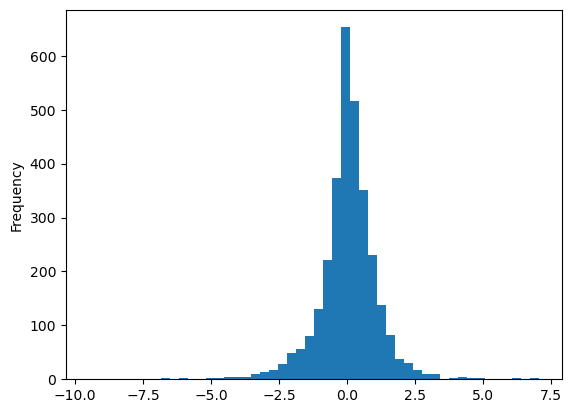

In [19]:
df=pd.read_csv("DataBase_final.csv")
df["S&P_Change_cc"].plot.hist(bins=50)

print("0.04% lowest values from Data : ", df["S&P_Change_cc"].quantile(q=0.04))

In [30]:
df=pd.read_csv("DataBase_final.csv")
df = df.drop(df.index[[0]])

SP_change_1=[]
SP_change_2=[]
i=0
j=-1
drop = []

df["S&P_Change_cc"] = df["S&P_Change_cc"].astype('float')

for t in df["S&P_Change_cc"]:
    if t < -2:
        SP_change_1.append(1)
    elif t > -2:
        SP_change_1.append(0)
    elif t == 0:
        SP_change_1.append(00)
    else:
        SP_change_1.append(00)

df["S&P_Change_crisis"]=SP_change_1 


for t in df["S&P_Change_cc"]:
    if t < 0:
        SP_change_2.append(1)
    elif t > 0:
        SP_change_2.append(0)
    elif t == 0:
        SP_change_2.append(00)
    else:
        SP_change_2.append(00)

df["S&P_Change_posneg"]=SP_change_2 


df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#Add a lag variable of the S&P
i=0
df_1 = concat([df.shift(1), df], axis=1)
df["S&P_Change_lag"]=df_1.iloc[:,18] #Cual es el numero de columna
df_2 = concat([df_1.shift(1), df], axis=1)
df_2.head()
df["S&P_Change_lag_lag"]=df_2.iloc[:,18]

df.to_csv("DATABASE_ML.csv")

In this section, an initial comparison between different Machine Learning algorithms is made to observe the different results obtained. 

It is important to mention that in this section it was decided to implement a filter of news_day. This was done because in the data from before 2019 there are some days that have very few news. This could potentially create a bias, as the selected new could mislead us from the true sentiment derived from news in that particular day.

/tmp/ipykernel_3705/1844017315.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.10/site-packag

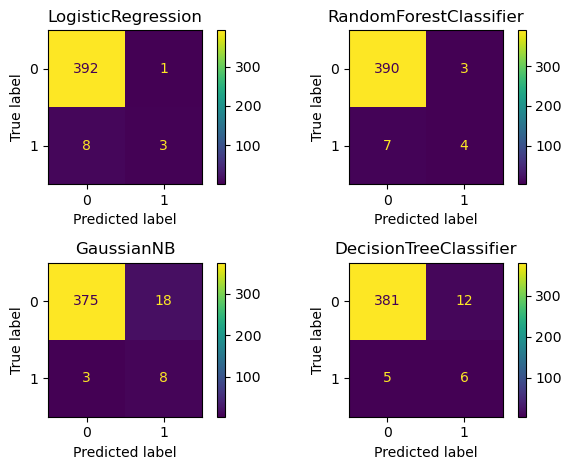

In [44]:
df_1 = pd.read_csv("DATABASE_ML.csv")
df_2 = df_1.loc[df_1['news_day'] > 30]

keep_columns = [ "Compound_avg","Positive_avg", "Negative_avg", "Volatility",
                        "polarity_avg" , "subjectivity_avg" ,"S&P_Change_crisis" ]

df = df_2[keep_columns]
X = df 
X = np.array(X.drop(["S&P_Change_crisis"],1))
y = np.array(df["S&P_Change_crisis"])
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)

def ml(mod):
    predictions = model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    print(classification_report(y_test,predictions))
    print(confusion_matrix(y_test,predictions))
    disp_=plot_confusion_matrix(model, x_test, y_test)

    
classifiers = [LogisticRegression(solver='lbfgs'), 
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier()]

for cls in classifiers:
    cls.fit(x_train, y_train)

fig, axes = plt.subplots(nrows=2, ncols=2)

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          x_test, 
                          y_test, 
                          ax=ax, )
                          #cmap='Blues',)
    ax.title.set_text(type(cls).__name__)

    plt.tight_layout()  
plt.show()


We observed that the Gaussian model is the one showing better results, for this reason the subsequent analysis was done exclusively to this model. Notwithstanding, we might have a better algorithm when different variables change (such as st.deviation filter that will be applied) , or variable selection for X. Further analysis could be done to better understand the behavior of different models. 

In this section we applied a "Standard Deviation Filter" the idea behind this is that the less standard deviation we have, the more certain the news of a particular day were. In other words, this might show an improvement of the prediction when we only use data with a certain certainty.   

In [2]:

compound = np.linspace(0.31, 0.56, 9)

for i in compound:
    df_1 = pd.read_csv("DATABASE_ML.csv")
    df_2 = df_1.dropna(axis=0)
    df_2 = df_2.loc[df_1['news_day'] > 30]
    df_2 = df_2.loc[df_2["Compound_day_st_dev"]< i]

    keep_columns = [ "Compound_avg","Positive_avg", "Negative_avg", "Volatility",
                        "polarity_avg" , "subjectivity_avg" ,"S&P_Change_crisis" ]
    
    df = df_2[keep_columns]
        
    X = df 
    X = np.array(X.drop(["S&P_Change_crisis"],1))
    y = np.array(df["S&P_Change_crisis"])

    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)

    model = GaussianNB().fit(x_train, y_train)
    predictions = model.predict(x_test)
    predictions = model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    print(f"St.dev = {i}")
    print(classification_report(y_test,predictions,target_names=["No fall", "Fall"]))
    
    #print(confusion_matrix(y_test,predictions))
    #disp_=plot_confusion_matrix(model, x_test, y_test)

/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument

St.dev = 0.31
              precision    recall  f1-score   support

     No fall       0.99      0.99      0.99       165
        Fall       0.86      0.86      0.86         7

    accuracy                           0.99       172
   macro avg       0.93      0.93      0.93       172
weighted avg       0.99      0.99      0.99       172

St.dev = 0.34125
              precision    recall  f1-score   support

     No fall       0.99      0.97      0.98       269
        Fall       0.42      0.71      0.53         7

    accuracy                           0.97       276
   macro avg       0.70      0.84      0.75       276
weighted avg       0.98      0.97      0.97       276

St.dev = 0.3725
              precision    recall  f1-score   support

     No fall       0.98      0.97      0.98       302
        Fall       0.33      0.36      0.35        11

    accuracy                           0.95       313
   macro avg       0.66      0.67      0.66       313
weighted avg       0.95    

/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/tmp/ipykernel_77/1023178416.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))


The results shows a slight improvement when applying this filter, for this reason we applied a filter with only news that have a < 0.3667 standard deviations. This number was chosen to have a proper balance of certainty and  still continue to have enough data to perform the training and testing. 

We included as well the Receiver Operating Characteristic (ROC) Curve to further continue with the analysis of the Machine Learning and the results asociated to the data.

/tmp/ipykernel_64/1710663335.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(X.drop(["S&P_Change_crisis"],1))
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


St.dev = 0.2413793103448276
              precision    recall  f1-score   support

     No fall       1.00      0.98      0.99       301
        Fall       0.53      0.89      0.67         9

    accuracy                           0.97       310
   macro avg       0.76      0.93      0.83       310
weighted avg       0.98      0.97      0.98       310

[[294   7]
 [  1   8]]


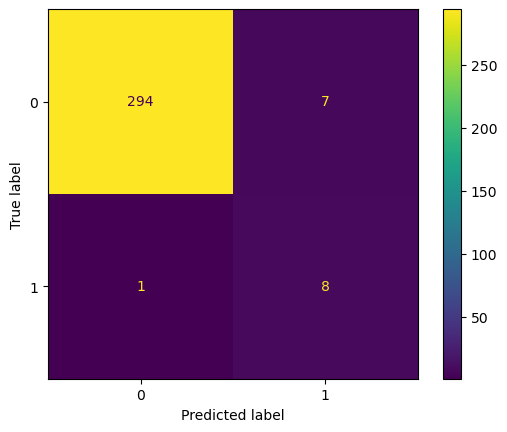

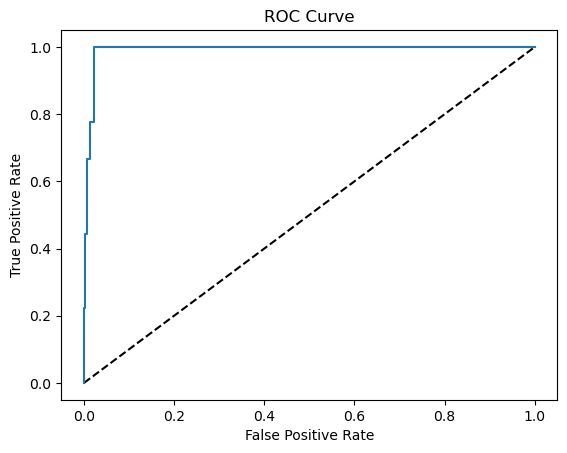

In [2]:
df_1 = pd.read_csv("DATABASE_ML.csv")
df_2 = df_1.dropna(axis=0)
df_2 = df_2.loc[df_1['news_day'] > 30] #5
df_2 = df_2.loc[df_2["Compound_day_st_dev"]< 0.3667]


keep_columns = [ "Compound_avg","Positive_avg", "Negative_avg", "Volatility",
                        "polarity_avg" , "subjectivity_avg" ,"S&P_Change_crisis" ]


df = df_2[keep_columns]      
X = df 
X = np.array(X.drop(["S&P_Change_crisis"],1))
y = np.array(df["S&P_Change_crisis"])

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)

model = GaussianNB().fit(x_train, y_train)
predictions = model.predict(x_test)
predictions = model.predict(x_test)
cm = confusion_matrix(y_test, predictions)
print(f"St.dev = {0.2413793103448276}")
print(classification_report(y_test,predictions,target_names=["No fall", "Fall"]))
print(confusion_matrix(y_test,predictions))
disp_=plot_confusion_matrix(model, x_test, y_test)

def plot_roc(mod, X, y):
    # predicted_probs is an N x 2 array, where N is number of observations
    # and 2 is number of classes
    predicted_probs = mod.predict_proba(x_test)

    # keep the second column, for label=1
    predicted_prob1 = predicted_probs[:, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, predicted_prob1)

    # Plot ROC curve
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")

plot_roc(model, x_test, y_test)

# Final Results

The algorithm allowed us to predict 89% of the Fall periods. This means that out of the 9 falls that the market had in the 310 tested days the program successfully predicted 8 of them. It is true that in 7 times the program predicted a fall even if it was not one, for this reason the program only has a 53% percent of precision. Nevertheless, we believe this number is low compared to the total amount of days that the market did not fall, on this day the precision was 99.99% and 98% predicted days. For this reason the weighted average was 98% por precision and 97% for recall.


# Conclusion 

This project showed that news articles sentiment together with other data may explain market movement. Despite having data from 2008 until 2022 the difference in ammount of news per day is important. While the latter months (News from Reuter) have 50 to 200 news per day, compared to other data with much less news. This lack of data was dealth with applying filters to minimize the bias, but this cause to only have 9 test day, which makes not very clear what is the exact precision of the Data.  






This project is a further development of the ESADE - Capstone project - review the project at: https://institute.eib.org/2022/06/when-ai-helps-predict-markets-moves/